In [1]:
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

## データの読み込み

以下のデータを使用しています。
https://github.com/MatsuuraKentaro/RStanBook/blob/master/chap04/input/data-salary.txt

In [2]:
df = pd.read_csv("./data-salary.txt")

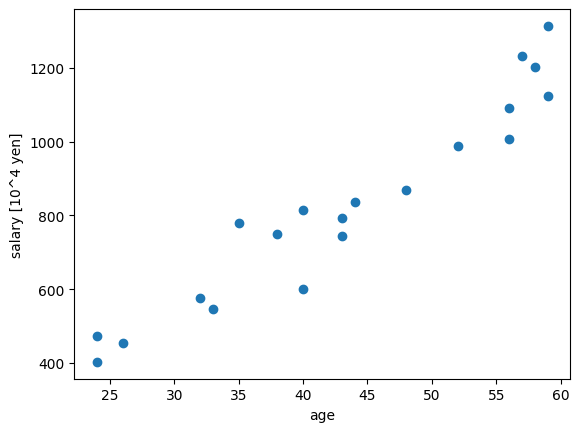

In [3]:
plt.scatter(df["X"], df["Y"])
plt.xlabel("age")
plt.ylabel("salary [10^4 yen]")
plt.show()

## モデル式

上記を見ると年齢と年収は線形に相関する年功序列の関係が強く現れていることがわかるので、線形の単回帰でモデル式を構築します。

$$
Y[n] \sim Normal(a + bX[n], \sigma)
$$

In [4]:
output_dir = "./output/"
os.makedirs(output_dir, exist_ok=True)

stan_file = "./simpleLR.stan"
exe_file = "./simpleLR"

### コンパイル

In [5]:
if not os.path.exists(exe_file):
    model = CmdStanModel(stan_file=stan_file)
else:
    model = CmdStanModel(exe_file=exe_file)

### データ

In [6]:
data = {
    "N": len(df),
    "X": df["X"].values,
    "Y": df["Y"].values,
}

print(data)

{'N': 20, 'X': array([24, 24, 26, 32, 33, 35, 38, 40, 40, 43, 43, 44, 48, 52, 56, 56, 57,
       58, 59, 59]), 'Y': array([ 472,  403,  454,  575,  546,  781,  750,  601,  814,  792,  745,
        837,  868,  988, 1092, 1007, 1233, 1202, 1123, 1314])}


### フィッティング

CmdStanPyでは以下の``sample()``メソッドにより、ハミルトンモンテカルロ(HMC)サンプリングを使って、データを条件としたモデルに対するベイズ推定を行います。このメソッドは、モデルとデータに対してStanのHMC-NUTSサンプラーを実行し、CmdStanMCMCオブジェクトを返します。

データは以下のようにPythonの辞書型でも渡せますし、ファイルパスを渡すこともできます。

In [7]:
import multiprocessing
num_cpu = multiprocessing.cpu_count()

In [8]:
fit = model.sample(
    data=data, 
    chains=4, # chain数
    seed=1, # seed固定
    iter_warmup=1000, # warmupの数
    iter_sampling=2000, # samplingの数
    parallel_chains=num_cpu, # 並列数
    save_warmup=True, # warmupもCSVに保存
    thin=1, # サンプリング間隔
    output_dir=output_dir, # 出力先
    # show_console=True, # 標準出力
    show_progress=True # progress出力
    )

22:41:41 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
22:41:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

22:41:41 - cmdstanpy - INFO - CmdStan done processing.


### 結果の確認

``fit.summary()``で各パラメータの要約が見られます。``lp__``は対数事後確率で他のパラメータ同様に収束する必要があります。

$\hat{R}$は収束を表すパラメータで「chain数が３以上でこの値が1.1以下」であることを収束したとみなしているようです。
また、N_EffはStanが自己相関等から判断した実効的なMCMCサンプル数です。この数が少ないと収束しづらいパラメータであることが分かります。大体1000サンプルほどあると良いものです。

In [9]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-93.6548,0.029373,1.30892,-96.2386,-93.3130,-92.21660,1985.76,7608.26,1.002850
a,-118.0040,1.570290,75.78320,-240.6490,-117.5970,6.50607,2329.10,8923.74,0.999964
b,21.8723,0.035007,1.68850,19.1097,21.8659,24.62840,2326.36,8913.26,0.999982
sigma,85.1516,0.283436,15.23270,63.9283,83.1896,113.48000,2888.31,11066.30,1.001140
y_base[1],406.9300,0.746408,38.04820,344.2550,407.0080,468.62300,2598.45,9955.76,0.999897
y_base[2],406.9300,0.746408,38.04820,344.2550,407.0080,468.62300,2598.45,9955.76,0.999897
y_base[3],450.6750,0.679555,35.18470,392.9970,450.7200,507.31600,2680.76,10271.10,0.999881
y_base[4],581.9090,0.484388,27.30770,537.2280,581.7580,625.99200,3178.22,12177.10,0.999806
y_base[5],603.7810,0.453155,26.14630,560.9400,603.7490,645.76100,3329.09,12755.10,0.999789
y_base[6],647.5250,0.392605,24.01180,608.1870,647.5920,686.14000,3740.55,14331.60,0.999750


### arvizによる収束性判断

In [10]:
import numpy as np
import arviz as az
import xarray as xr
az.style.use("arviz-darkgrid")

cmdstanpyからarviz用のデータへ変換

In [11]:
cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)
cmdstanpy_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [12]:
ll_data = cmdstanpy_data.log_likelihood

対数事後確率のプロット

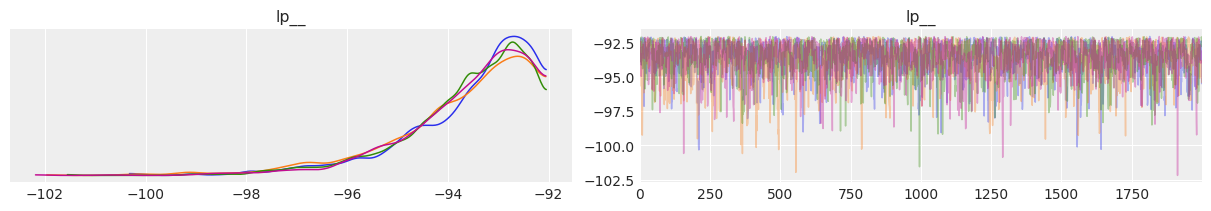

In [13]:
az.plot_trace(ll_data, compact=False);

#### 自己相関プロット

ほとんど自己相関がないことがわかる

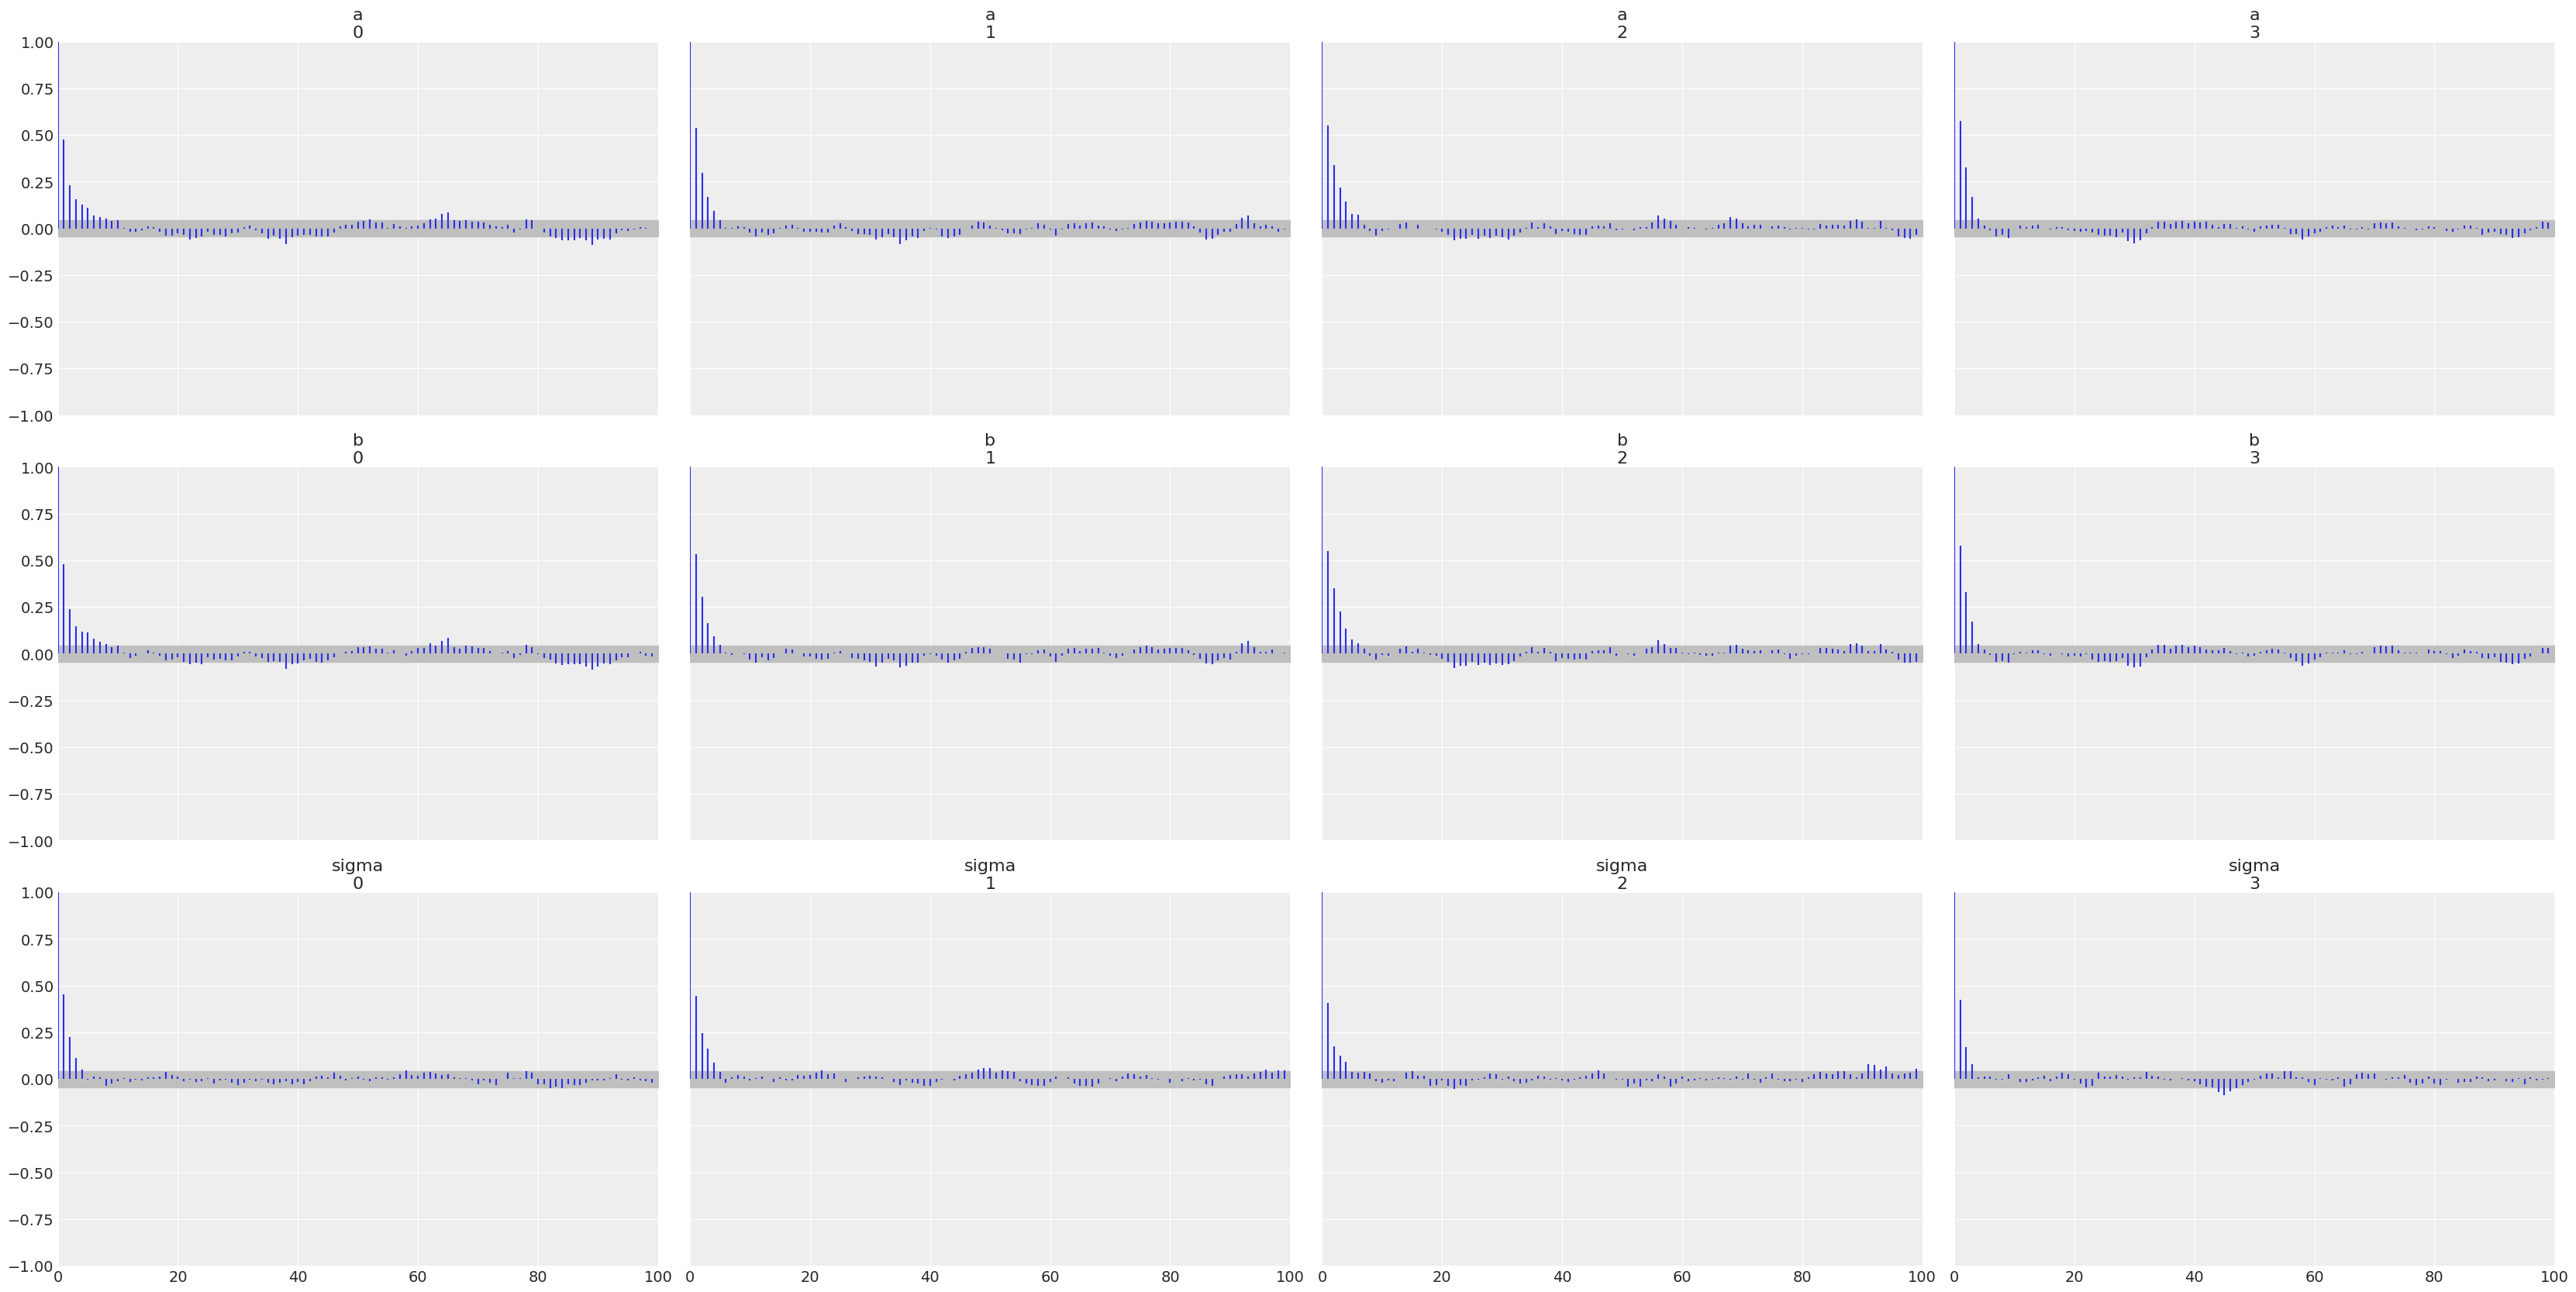

In [14]:
az.plot_autocorr(cmdstanpy_data, grid=(3, 4), var_names=["a", "b", "sigma"]);

#### 事後分布のプロット

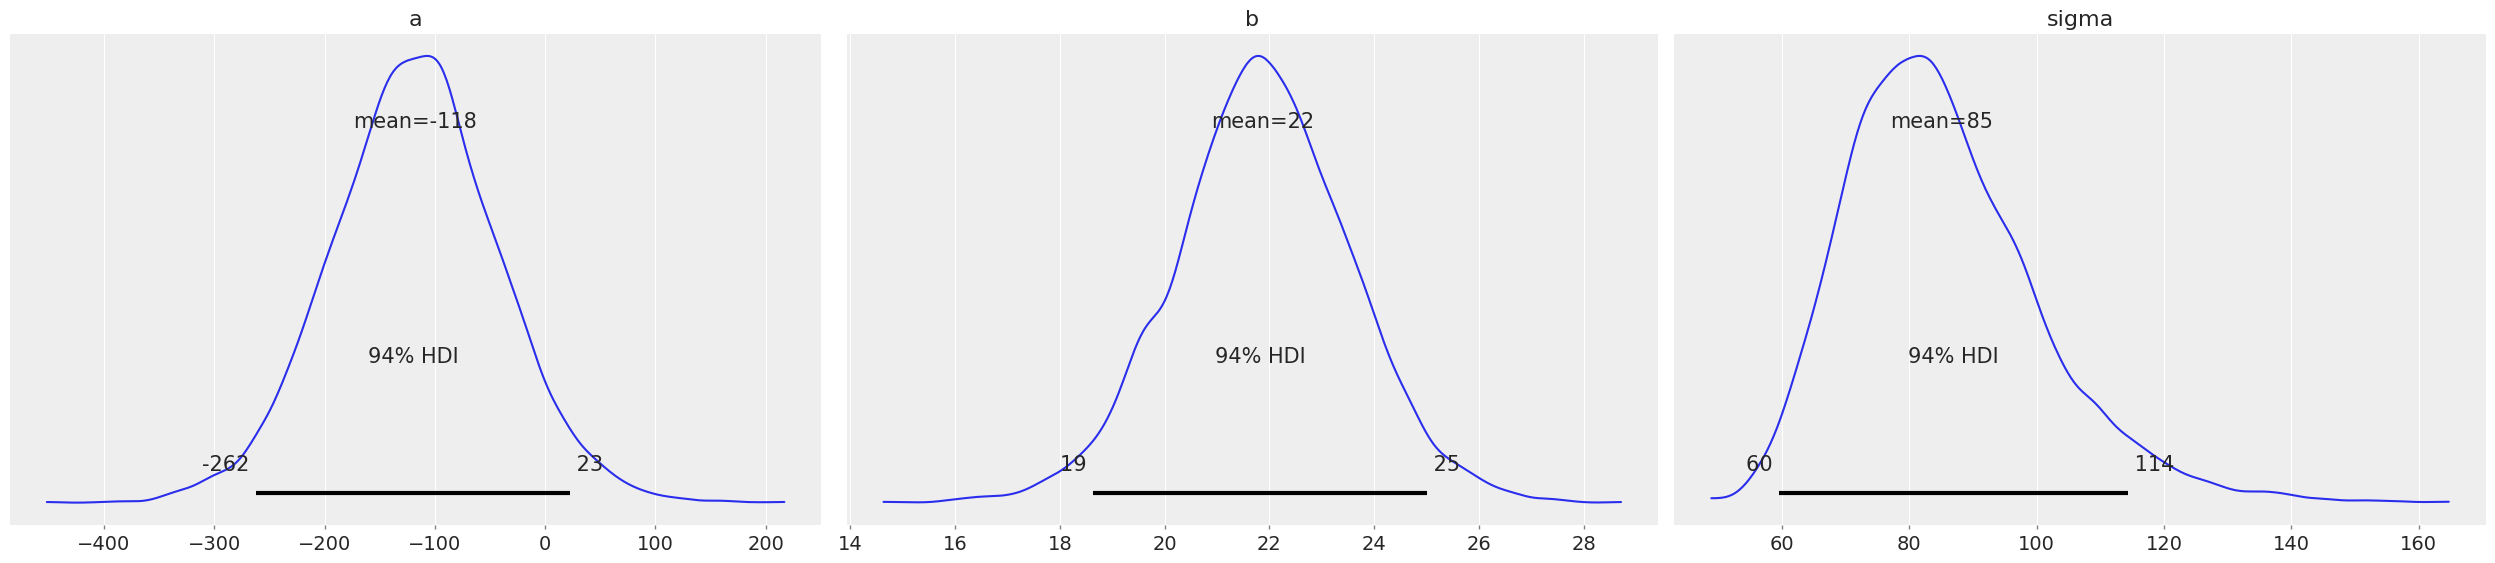

In [15]:
az.plot_posterior(cmdstanpy_data, var_names=["a", "b", "sigma"]);

#### トレースプロット

ある点を中心にプロットされているので収束していることがわかる。

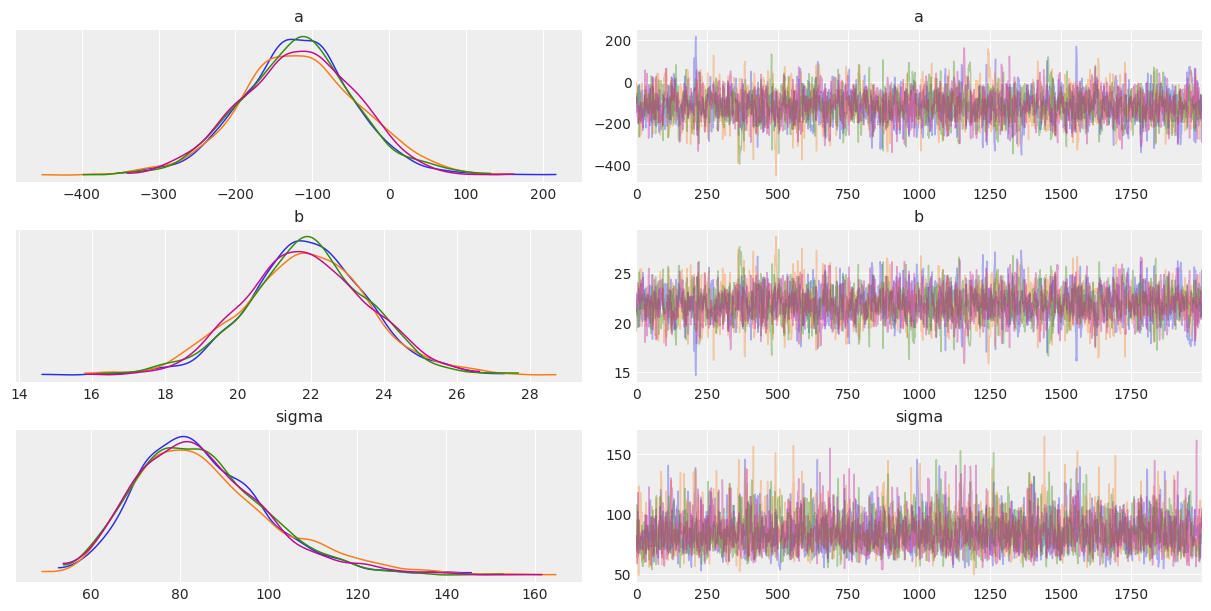

In [16]:
az.plot_trace(cmdstanpy_data, compact=False, var_names=["a", "b", "sigma"]);

#### パラメータのペアプロット

``a``と``b``は負の相関があることがわかる。

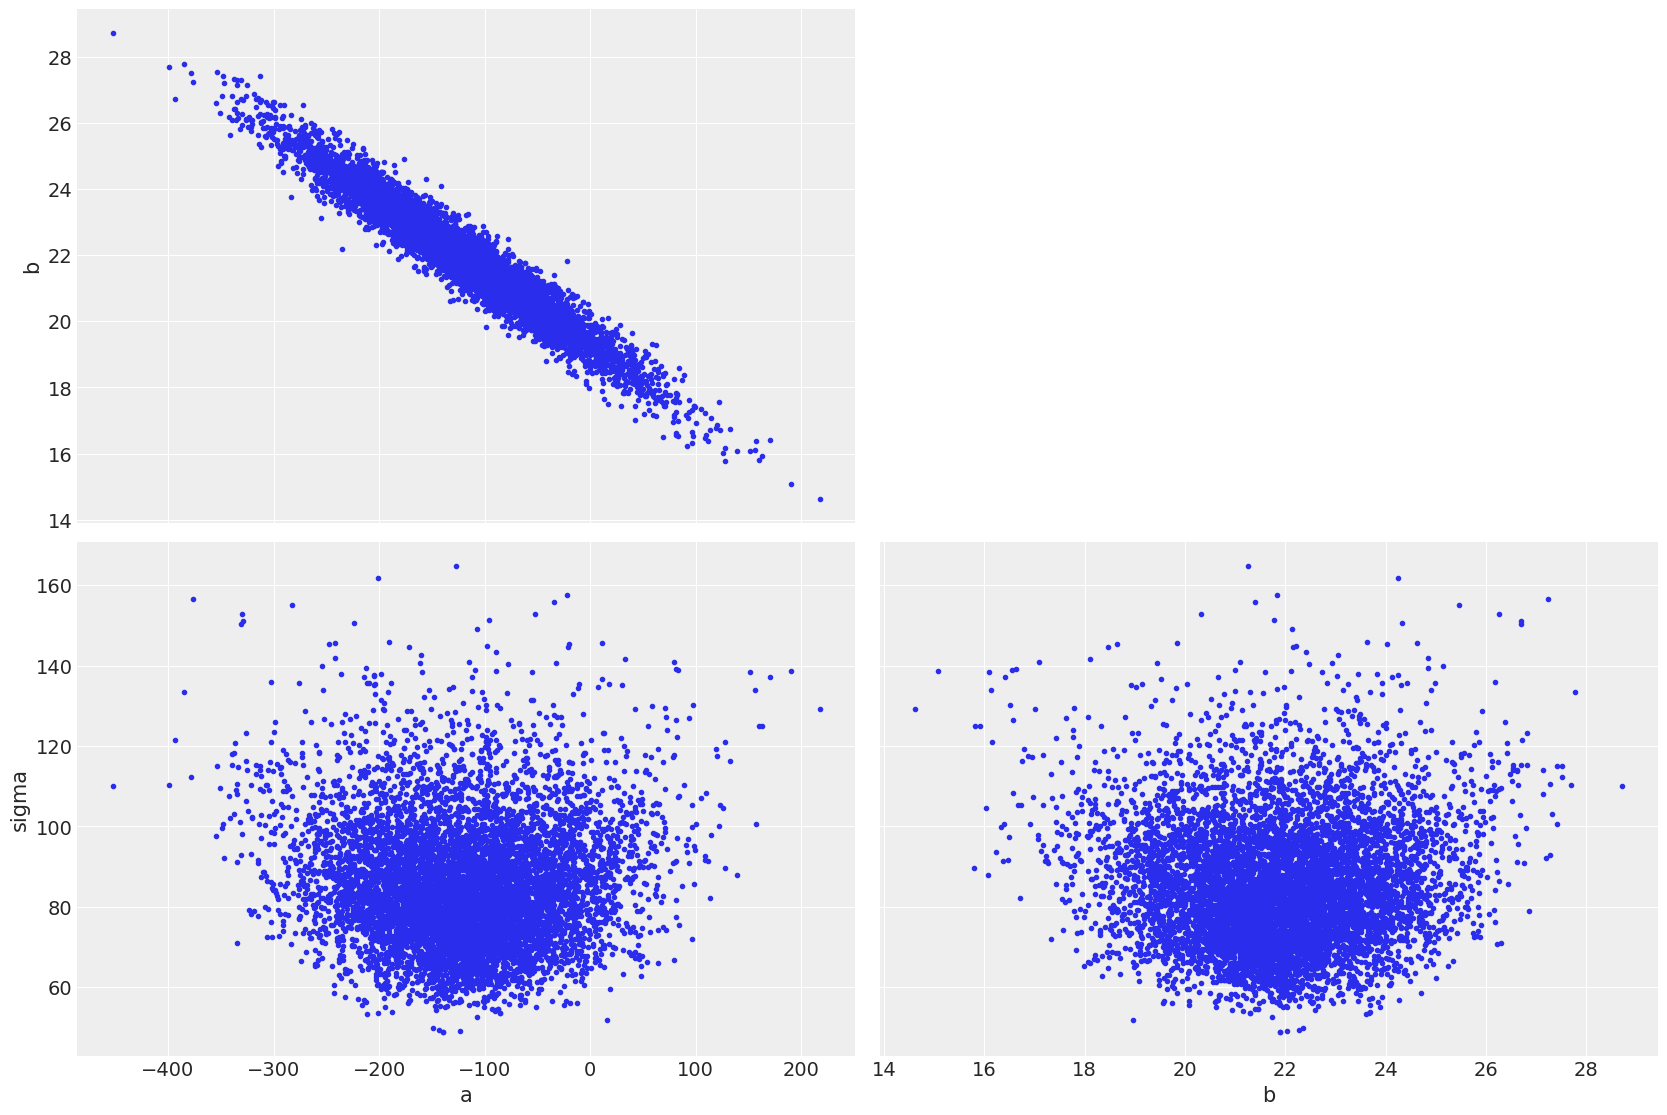

In [17]:
az.plot_pair(
    cmdstanpy_data,
    divergences=True,
    var_names=["a", "b", "sigma"]
);

### ベイズ信頼区間とベイズ予測区間

generate_quantities blockを用いて、23~60歳までの基本年収のベイズ信頼区間と年収のベイズ予測区間を計算し可視化します。

generate_quantities blockはパラメータや定数から新たにサンプリングする変数を作ることができます。この時、事後確率からは切り離されているので計算が早いのが特徴です。

In [18]:
data = {
    "N": len(df),
    "X": df["X"].values,
    "Y": df["Y"].values,
    "N_new": len(list(range(23, 61))),
    "X_new": list(range(23, 61))
}

print(data)

{'N': 20, 'X': array([24, 24, 26, 32, 33, 35, 38, 40, 40, 43, 43, 44, 48, 52, 56, 56, 57,
       58, 59, 59]), 'Y': array([ 472,  403,  454,  575,  546,  781,  750,  601,  814,  792,  745,
        837,  868,  988, 1092, 1007, 1233, 1202, 1123, 1314]), 'N_new': 38, 'X_new': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]}


``simpleLR.stan``が無事に収束していることを確認した後に、generate_quantities blockが追加された``simpleLR_ppc.stan``をコンパイルし実行します。

In [19]:
ppc_model = CmdStanModel(stan_file='simpleLR_ppc.stan')
ppc_model.compile()
new_quantities = ppc_model.generate_quantities(data=data, mcmc_sample=fit, seed=1)

22:41:44 - cmdstanpy - WARNING - Sample contains saved warmup draws which will be used to generate additional quantities of interest.
22:41:44 - cmdstanpy - INFO - Chain [1] start processing
22:41:44 - cmdstanpy - INFO - Chain [2] start processing
22:41:44 - cmdstanpy - INFO - Chain [3] start processing
22:41:44 - cmdstanpy - INFO - Chain [4] start processing
22:41:45 - cmdstanpy - INFO - Chain [3] done processing
22:41:45 - cmdstanpy - INFO - Chain [4] done processing
22:41:45 - cmdstanpy - INFO - Chain [2] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing


50%と95%信頼区間を計算しプロットします。

In [20]:
df_result = new_quantities.draws_pd().describe(percentiles=[.025, .05, .25, .5, .75, .95, .975])
df_result

,y_base_new[1],y_base_new[2],y_base_new[3],y_base_new[4],y_base_new[5],y_base_new[6],y_base_new[7],y_base_new[8],y_base_new[9],y_base_new[10],...,y_new[29],y_new[30],y_new[31],y_new[32],y_new[33],y_new[34],y_new[35],y_new[36],y_new[37],y_new[38]
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,385.058119,406.930390,428.802665,450.674948,472.547218,494.419496,516.291769,538.164050,560.036322,581.908599,...,997.178968,1017.497877,1042.367610,1065.202821,1089.527130,1106.467963,1132.692316,1150.835826,1171.397598,1191.921657
std,39.510349,38.048189,36.605522,35.184719,33.788571,32.420251,31.083426,29.782353,28.521913,27.307741,...,89.503675,91.000251,91.840605,90.831608,91.650658,91.867487,90.019446,92.852240,92.842977,95.362284
min,208.235000,236.958000,265.680000,294.402000,323.125000,351.847000,380.570000,408.663000,435.386000,462.110000,...,604.596000,640.133000,632.950000,681.398000,629.154000,745.339000,768.960000,771.226000,810.726000,848.899000
2.5%,306.433425,330.820475,355.192075,380.105675,405.071850,429.729600,454.208650,478.841550,503.355600,527.382625,...,819.167150,837.805100,867.149750,886.526100,911.713750,923.326875,961.092275,965.016175,989.017350,1009.480750
5%,319.988450,344.287300,368.869500,392.997000,417.094650,440.881850,465.224400,489.284650,513.274750,537.235650,...,847.073350,868.299250,893.432350,920.508050,939.836550,954.241600,988.222750,996.769900,1020.267000,1038.406500
25%,359.199000,382.192000,405.059000,427.902500,450.733000,473.541750,496.412750,519.107500,541.912000,564.482500,...,940.439000,959.116500,981.171250,1005.422500,1030.080000,1045.355000,1074.727500,1091.930000,1111.032500,1128.815000
50%,385.058500,407.003000,428.870000,450.717000,472.623000,494.374000,516.168000,538.070000,559.996500,581.756000,...,998.690000,1017.610000,1042.660000,1064.040000,1089.560000,1107.575000,1129.950000,1152.065000,1173.035000,1190.375000
75%,410.990750,432.058000,453.062750,474.066750,495.127000,515.999500,536.971750,557.953500,578.973250,600.068250,...,1055.585000,1074.862500,1102.355000,1123.417500,1147.540000,1165.432500,1189.512500,1209.710000,1231.780000,1253.532500
95%,449.053150,468.623600,488.028950,507.321800,527.144950,546.890450,566.492450,586.221900,605.865550,625.997350,...,1140.883500,1166.923500,1193.994500,1213.292000,1241.145000,1256.693500,1283.842500,1300.693000,1322.934000,1347.761000


In [21]:
df_base = df_result.loc[:, df_result.columns.str.contains("base")].T
df_base["age"] = list(range(23, 61))
df_base.head(3)

,count,mean,std,min,2.5%,5%,25%,50%,75%,95%,97.5%,max,age
y_base_new[1],8000.0,385.058119,39.510349,208.235,306.433425,319.98845,359.199,385.0585,410.99075,449.05315,463.058075,553.886,23
y_base_new[2],8000.0,406.930390,38.048189,236.958,330.820475,344.28730,382.192,407.0030,432.05800,468.62360,481.712725,568.508,24
y_base_new[3],8000.0,428.802665,36.605522,265.680,355.192075,368.86950,405.059,428.8700,453.06275,488.02895,501.030925,583.131,25


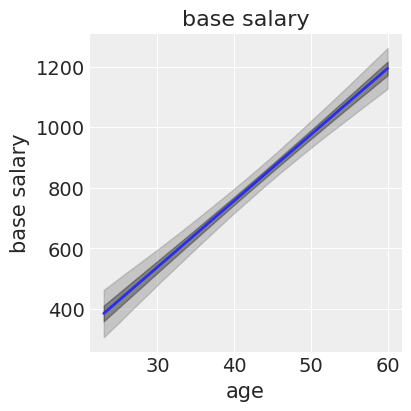

In [22]:
plt.figure(figsize=(4, 4))
plt.plot(df_base["age"], df_base["mean"], '-', linewidth=2)
plt.fill_between(df_base["age"], df_base["2.5%"], df_base["97.5%"], color='#888888', alpha=0.4)
plt.fill_between(df_base["age"], df_base["25%"], df_base["75%"], color='#222222', alpha=0.4)
plt.xlabel("age"); plt.ylabel("base salary")
plt.title("base salary")
plt.tight_layout()
plt.show()

In [23]:
df_new = df_result.loc[:, df_result.columns.str.contains("y_new")].T
df_new["age"] = list(range(23, 61))
df_new.head(3)

,count,mean,std,min,2.5%,5%,25%,50%,75%,95%,97.5%,max,age
y_new[1],8000.0,385.978724,92.853334,-14.99260,204.730600,236.73215,325.83075,386.3695,445.46325,537.02460,565.949625,803.756,23
y_new[2],8000.0,404.487225,93.400021,-48.95050,219.343725,253.03440,344.93450,402.9470,464.63100,558.62205,588.770850,779.516,24
y_new[3],8000.0,429.163955,93.926930,3.38044,241.006300,275.97365,368.42175,429.6830,489.73050,583.25325,614.629200,808.725,25


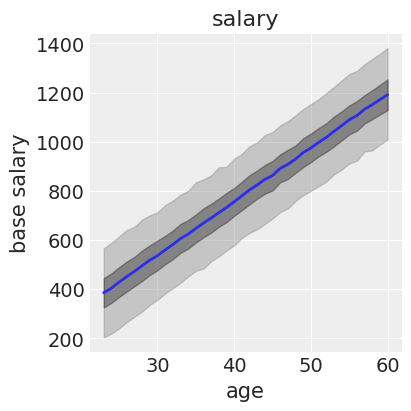

In [24]:
plt.figure(figsize=(4, 4))
plt.plot(df_new["age"], df_new["mean"], '-', linewidth=2)
plt.fill_between(df_new["age"], df_new["2.5%"], df_new["97.5%"], color='#888888', alpha=0.4)
plt.fill_between(df_new["age"], df_new["25%"], df_new["75%"], color='#222222', alpha=0.4)
plt.xlabel("age"); plt.ylabel("base salary")
plt.title("salary")
plt.tight_layout()
plt.show()